In [3]:
import os
import sys
import numpy as np
import random
from random import uniform
import copy

import matplotlib.pyplot as plt

# local application imports 
import database.config as config
import preprocessing.data_preprocessing.data_utils as data_utils
import annotation.stimulus_driven_annotation.movies.processing_labels as processing_labels
import preprocessing.data_preprocessing.create_vectors_from_time_points as create_vectors_from_time_points

import preprocessing.data_preprocessing.binning as binning

Please enter DataJoint username:  root
Please enter DataJoint password:  ···············


Connecting root@localhost:3306


In [197]:
"""
Functions related to generating mock data. 
"""


    
    
def generate_spikes(patient_id, session_nr, nr_units, begin_recording_time, stop_recording_time):
    """
    Generates mock spike trains for a "patient."
    
    Writes spike trains to file as numpy binaries. 
    
    """
    spikes = []
    for i in range(nr_units):
        nr_spikes = int(uniform(10000, 16000))
        spike_vec = []
        for j in range(nr_spikes):
            spike_vec.append(uniform(begin_recording_time, stop_recording_time))
        spike_vec = np.sort(spike_vec)
        spikes.append(spike_vec)

    return spikes 
#     # Directory set-up
#     save_dir = "{}/mock_data/patient_data/{}/session_{}/spiking_data/".format(config.PATH_TO_REPO, patient_id, session_nr)

#     if not os.path.exists(save_dir):
#         os.makedirs(save_dir)

#     unit_types = ['M', 'S']
#     for i in range((nr_units)):
#         ## NOTE: because of the random naming scheme, re-running this
#         ## code will cause issues later in the pipeline (too many file for 
#         ## number of expected units)
#         np.save(os.path.join(save_dir, "CSC{}_{}UA{}.npy".format(i+1, random.choice(unit_types), '1')), spikes[i])    
    

def generate_channel_file(patient_id, session_nr, nr_unit, nr_units_per_brain_region=None):
    """
    Generates ChannelNames.txt file. 
    
    If not given an array-like containing the number of units to 
    assign to each brain region, will automatically generate. 
    """
    brain_regions = ["LA", "LAH", 'LEC', "LMH", "LPHC", "RA", "RAH", "REC", "RMH", "RPCH"]

    # Generate number of units per brain region
    if not nr_units_per_brain_region:
        nr_units_per_brain_region = []
        
        seed = nr_unit / 10
        counter = nr_unit
        for i in range(len(brain_regions)):
            if i != len(brain_regions):
                random_int = int(np.random.normal(loc=seed, scale=2.0))
                nr_units_per_brain_region.append(random_int)
                counter -= random_int 
            if i == len(brain_regions):
                nr_units_per_brain_region.append(counter)
                
    assert sum(nr_units_per_brain_region) == nr_unit, "Number of units per brain region doesn't match total units."
      
    #return nr_units_per_brain_region
    
    channel_save_dir = "/home/hitchhiker/Documents/DeepHumanVision_deploy/mock_data/ChannelNames.txt"
    
    f1 = open(channel_save_dir, 'w+')
    for i in range(len(nr_units_per_brain_region)):
        for j in range(nr_units_per_brain_region[i]):
            f1.write("{}{}.ncs\n".format(brain_regions[i], j+1))

    f1.close()
    
    
def generate_pings():
    """
    Recreate how Neurolynx interfaces with a local computer. 
    """
    len_context_files = random.randint(4000, 5400) # generate length of events.nev & DAQ file. 

    # recreate pings
    if len_context_files % 8 == 0:
        reps = int(len_context_files / 8)
    else:
        reps = int(len_context_files / 8) + 1

    signal_tile = np.tile([1,2,4,8,16,32,64,128], reps)
    signal_tile = signal_tile[:len_context_files]
    
    return len_context_files, signal_tile
    
def generate_events(patient_id, session_nr, len_context_files, signal_tile, begin_recording_time, stop_recording_time):
    """
    Generate mock Events.nev file. Save as Events.npy file. 
    """
    
    # recreate event timestamps
    events = np.linspace(begin_recording_time, stop_recording_time, num=len_context_files)

    events_mat = np.array(list(zip(events, signal_tile)))


    evname_save = "/home/hitchhiker/Documents/DeepHumanVision_deploy/mock_data/Events.npy"

    if os.path.exists(evname_save):
        os.remove(evname_save)

    np.save(evname_save, events_mat)
    
#     return events_mat
    
def generate_daq_log(patient_id, session_nr, len_context_files, signal_tile, begin_recording_time, stop_recording_time, seed=1590528227608515, stimulus_len=83.816666):
    """
    Generate mock DAQ log. 
    
    Must use same values for signal_tile and len_context_files as the events.nev mock-up
    
    params:
    stimulus_len: length of the stimulus presentation, in minutes
    
    """
#    events = np.linspace(begin_recording_time, stop_recording_time, num=len_context_files)
#     diffs = np.diff(events)
#     diffs = np.insert(diffs, 0, 0)
    
    
    
    #uses same values for signal_tile and len_context_files as the events.nev mock-up
    values = signal_tile
    index = np.arange(len_context_files)
    
    # generate projected end time for the DAQ log, in unix time microseconds
    #movie_len_unix = (stimulus_len * 60 * 1000 * 1000)
    rec_len_unix = (stop_recording_time - begin_recording_time) 
    
    end_time = seed + rec_len_unix 
    add_interval = int((end_time - seed) / len_context_files)
    
    print("Recording length, in usec: ", rec_len_unix)
    print("End time of recording, in epoch time: ",end_time)
    print("Length of interval iteratively added: ", add_interval)
    
    pre = []
    post = []

    for i in range(len_context_files):
        interval_diff = (np.random.normal(1000, 200) / 2)

        pre.append(int(seed - interval_diff))
        post.append(int(seed + interval_diff))
        #seed += np.random.normal(1000144, 100)
        seed += add_interval 
        
    log_lines = list(zip(values, index, pre, post))


    logname_save = "/home/hitchhiker/Documents/DeepHumanVision_deploy/mock_data/timedDAQ-log-20200526-232347.log"

    if os.path.exists(logname_save):
        os.remove(logname_save)

    with open(logname_save, 'a') as file:
        file.write("Initial signature: 255	255\n255\t255\t\ndata\tStamp\tpre\tpost\n")
        for datum in log_lines:
            file.write("{}\t{}\t{}\t{}\n".format(datum[0], datum[1], datum[2], datum[3]))
        file.close()
    
    #return values, index, pre, post

    
def generate_perfect_watchlog(patient_id, session_nr, seed=1590528227608515):
    """
    Generate a movie watchlog file without pauses or skips.
    """

    nr_movie_frames = 125725      # movie length: 5029 seconds (AVI file); 5029/0.04 = 125725
    perfect_pts = [round((x * 0.04), 2) for x in range(1, nr_movie_frames+1)]  
    
    pause_pool = 5 * 1000 * 1000 * 60 # 5 minutes in unix/epoch time -- use for max pause time
    
    wl_seed = seed + 1e9
    # generate projected end time for the DAQ log, in unix time microseconds
    movie_len_unix = (stimulus_len * 60 * 1000 * 1000) - pause_pool
    end_time = seed + movie_len_unix 
    add_interval = int((end_time - seed) / nr_movie_frames)
    
    print("Length of the stimulus, in usec: ", movie_len_unix)
    print("End of stimulus, in epoch time: ", end_time)
    print("Length of interval iteratively added : ", add_interval)
    
    cpu_time = []
    
    for i in range(nr_movie_frames):
        wl_seed += add_interval
        cpu_time.append(int(wl_seed))   
    
    ####
    
    ## add in pauses
    nr_pauses = int(uniform(1,6))
    min_pause = 0.1 * 1000 * 1000 * 60
    
    # randomly select indices from perfect watchlog 
    indices_pause = random.sample(range(len(cpu_time) - 5000), nr_pauses)
        
    cpu_time = np.array(cpu_time)
    
    for i, index in enumerate(indices_pause): 
        if (len(indices_pause) - i) > 0: 
            pause_len = random.randint(min_pause, pause_pool)
            #pause_len = int(random.sample(range(min_pause, pause_pool))) ## TODO: this might be causing too big a difference btw wl and daq
            cpu_time = np.concatenate((cpu_time[:index],cpu_time[index:] + pause_len)) 
            pause_pool -= pause_len
        else:
            pause_len = pause_pool
            cpu_time = np.concatenate((cpu_time[:index],cpu_time[index:] + pause_len))

    # randomly select indices from perfect watchlog 
    nr_skips = int(uniform(1,4))
    
    indices_skip = random.sample(range(len(perfect_pts) - 5000), nr_skips)

    skip_pts = np.array(copy.copy(perfect_pts))
    
    max_skip = 500

    for i, index in enumerate(indices_skip): 
        # note: careful about values here -- can exceed mocked movie length. 
        # currently set so that the max possible skip is the penultimate frame
        if len(indices_skip) > 1:
            skip_len = int(uniform((max_skip * -1), max_skip))
            skip_pts = np.concatenate((skip_pts[:index],skip_pts[index:] + skip_len)) 
            max_skip -= skip_len

        if len(indices_skip) == 1:
            skip_len = max_skip
            skip_pts = np.concatenate((skip_pts[:index],skip_pts[index:] + skip_len)) 

    # test for rounding issue
    skip_pts = [round(frame, 2) for frame in skip_pts]

    # prevents generated frame from exceeding the mock movie length
    skip_pts_revised = []
    for i, frame in enumerate(skip_pts):
        if frame > (nr_movie_frames * 0.04):
            skip_pts_revised.append(nr_movie_frames * 0.04)
        if frame <= (nr_movie_frames * 0.04):
            skip_pts_revised.append(frame)
        if frame < 0: 
            skip_pts_revised.append(0.0)
    
    ####
    wl_name_save = "/home/hitchhiker/Documents/DeepHumanVision_deploy/mock_data/ffplay-watchlog-20200526-232347.log"

    if os.path.exists(wl_name_save):
        os.remove(wl_name_save)

    with open(wl_name_save, 'a') as file:
        file.write("movie_stimulus.avi\n")
        for i in range(nr_movie_frames):
            #file.write("pts\t{}\ttime\t{}\n".format(perfect_pts[i], cpu_time[i]))
            file.write("pts\t{}\ttime\t{}\n".format(skip_pts_revised[i], cpu_time[i]))
        file.close()
        
        
def generate_playback_artifacts(patient_id, session_nr, seed=1590528227608515, stimulus_len=83.816666):
    """
    Generate a movie watchlog file with pauses and skips.
    """
    
    nr_movie_frames = 125725      # movie length: 5029 seconds (AVI file); 5029/0.04 = 125725
    perfect_pts = [round((x * 0.04), 2) for x in range(1, nr_movie_frames+1)]  

    wl_seed = seed + 1e9
    # generate projected end time for the DAQ log, in unix time microseconds
    movie_len_unix = (stimulus_len * 60 * 1000 * 1000)
    end_time = seed + movie_len_unix 
    add_interval = int((end_time - seed) / nr_movie_frames)
    
    print(movie_len_unix)
    print(end_time)
    print(add_interval)
    
    cpu_time = []
    
    for i in range(nr_movie_frames):
        wl_seed += add_interval
        cpu_time.append(int(wl_seed))    
        
    ## add in pauses
    nr_pauses = int(uniform(1,6))

    # randomly select indices from perfect watchlog 
    indices_pause = random.sample(range(len(cpu_time) - 5000), nr_pauses)
    
    cpu_time = np.array(cpu_time)
    
    for i, index in enumerate(indices_pause): 
        pause_len = int(uniform(1e9, 3e9)) ## TODO: this might be causing too big a difference btw wl and daq
        cpu_time = np.concatenate((cpu_time[:index],cpu_time[index:] + pause_len)) 
        
    nr_skips = int(uniform(1,4))

    # randomly select indices from perfect watchlog 
    indices_skip = random.sample(range(len(perfect_pts) - 5000), nr_skips)

    skip_pts = np.array(copy.copy(perfect_pts))
    
    max_skip = 500

    for i, index in enumerate(indices_skip): 
        # note: careful about values here -- can exceed mocked movie length. 
        # currently set so that the max possible skip is the penultimate frame
        if len(indices_skip) > 1:
            skip_len = int(uniform((max_skip * -1), max_skip))
            skip_pts = np.concatenate((skip_pts[:index],skip_pts[index:] + skip_len)) 
            max_skip -= skip_len

        if len(indices_skip) == 1:
            skip_len = max_skip
            skip_pts = np.concatenate((skip_pts[:index],skip_pts[index:] + skip_len)) 

    # test for rounding issue
    skip_pts = [round(frame, 2) for frame in skip_pts]

    # prevents generated frame from exceeding the mock movie length
    skip_pts_revised = []
    for i, frame in enumerate(skip_pts):
        if frame > (nr_movie_frames * 0.04):
            skip_pts_revised.append(nr_movie_frames * 0.04)
        if frame <= (nr_movie_frames * 0.04):
            skip_pts_revised.append(frame)
        if frame < 0: 
            skip_pts_revised.append(0.0)
    
    wl_name_save = "/home/hitchhiker/Documents/DeepHumanVision_deploy/mock_data/ffplay-watchlog-20200526-232347.log"

    if os.path.exists(wl_name_save):
        os.remove(wl_name_save)
    
    with open(wl_name_save, 'a') as file:
        file.write("movie_stimulus.avi\n")
        for i in range(nr_movie_frames):
            if i not in indices_pause:
                file.write("pts\t{}\ttime\t{}\n".format(skip_pts_revised[i], cpu_time[i]))
            if i in indices_pause: 
                file.write("Pausing\nContinuing\tafter\tpause\n")

    file.close()
    
            
            
#    return skip_pts_revised, cpu_time
#     wlsave_dir = "{}/mock_data/patient_data/{}/session_{}/watchlogs/".format(config.PATH_TO_REPO, patient_id, session_nr)

#     if not os.path.exists(wlsave_dir):
#         os.makedirs(wlsave_dir)

#     wl_name_save = "{}/mock_data/patient_data/{}/session_{}/watchlogs/ffplay-watchlog-20200526-232347.log".format(config.PATH_TO_REPO, patient_id, session_nr)


        
#     with open(wl_name_save, 'a') as file:
#         file.write("movie_stimulus.avi\n")
#         for i in range(nr_movie_frames):
#             if i not in indices_pause:
#                 file.write("pts\t{}\ttime\t{}\n".format(skip_pts_revised[i], cpu_time[i]))
#             if i in indices_pause: 
#                 file.write("Pausing\nContinuing\tafter\tpause\n")
    
#     file.close()

    
def make_events_and_daq(patient_id, session_nr, begin_recording_time, stop_recording_time, seed=1590528227608515, stimulus_len=83.816666):
    """
    Put together events and daq code, compute all at once. 
    """
    len_context_files, signal_tile = generate_pings()
    
    generate_events(patient_id, session_nr, len_context_files, signal_tile, begin_recording_time, stop_recording_time)
    generate_daq_log(patient_id, session_nr, len_context_files, signal_tile, seed, stimulus_len)

    

In [116]:
nr_movie_frames = 125725      # movie length: 5029 seconds (AVI file); 5029/0.04 = 125725
perfect_pts = [round((x * 0.04), 2) for x in range(1, nr_movie_frames+1)]  

wl_seed = seed + 1e9
# generate projected end time for the DAQ log, in unix time microseconds
movie_len_unix = (stimulus_len * 60 * 1000 * 1000)
end_time = seed + movie_len_unix 
add_interval = int((end_time - seed) / nr_movie_frames)

print(movie_len_unix)
print(end_time)
print(add_interval)

cpu_time = []

for i in range(nr_movie_frames):
    wl_seed += add_interval
    cpu_time.append(int(wl_seed)) 

5028999960.0
1590533256608475.0
39999


In [191]:
print(5 * 1000 * 1000 * 60)

300000000


In [185]:
(wl_seed - seed) / 1000 / 1000 / 60 

100.48123791666667

In [195]:
patient_id = 1
session_nr = 1

nr_units_patient_1 = 100
begin_recording_time = 449860058000
stop_recording_time =  455889058000
nr_units_per_brain_region_1 = [7, 12, 9, 10, 15, 13, 8, 11, 12, 3]

seed=1590528227608515
stimulus_len=83.816666

In [198]:
spikes = generate_spikes(patient_id, session_nr, nr_units_patient_1, begin_recording_time, stop_recording_time)
generate_channel_file(patient_id, session_nr, nr_units_patient_1, nr_units_per_brain_region_1)


len_context_files, signal_tile = generate_pings()
generate_events(patient_id, session_nr, len_context_files, signal_tile, begin_recording_time, stop_recording_time)
generate_daq_log(patient_id, session_nr, len_context_files, signal_tile, begin_recording_time, stop_recording_time, seed, stimulus_len)

generate_perfect_watchlog(patient_id, session_nr)
#generate_playback_artifacts(patient_id, session_nr)

Recording length, in usec:  6029000000
End time of recording, in epoch time:  1590534256608515
Length of interval iteratively added:  1311507
Length of the stimulus, in usec:  4728999960.0
End of stimulus, in epoch time:  1590532956608475.0
Length of interval iteratively added :  37613


In [199]:
wl = "ffplay-watchlog-20200526-232347.log"
dq = "timedDAQ-log-20200526-232347.log"
ev = "Events.npy"

tc = data_utils.TimeConversion(wl, dq, ev)
pts, daq_time, cpu_time = tc.convert()
convert_start, convert_stop = tc.convert_pauses()
start_values, stop_values, values = tc.convert_skips()

Min Daq Diff: 0.2 ms, Max Daq Diff: 1.7 ms
Maximum Error after Event fit: 0.4 ms
Min Daq Diff: 0.2 ms, Max Daq Diff: 1.7 ms
Maximum Error after Event fit: 0.4 ms
Min Daq Diff: 0.2 ms, Max Daq Diff: 1.7 ms
Maximum Error after Event fit: 0.4 ms
There is a skip in the movie frame playback that is bigger than 25.0 frames.
The biggest skip is 10074.0 frames.
Timepoints of skips, in neural_rec_time: [4.52841558e+11 4.54504453e+11]
Start timepoints: [450860313088.0, 452841595875.25, 454504490461.25]
Stop timepoints: [452841558254.0, 454504452840.25, 455867866812.25]



In [200]:
unit = spikes[0] / 1000

In [201]:
bin_size = 1000

rectime = daq_time / 1000
rec_on = rectime[0]
rec_off = rectime[-1]

total_msec = rec_off - rec_on
total_bins = int(total_msec / bin_size)
bins = np.linspace(rec_on, rec_off, total_bins)

In [202]:
rectime

array([4.50860313e+08, 4.50860351e+08, 4.50860388e+08, ...,
       4.55867792e+08, 4.55867829e+08, 4.55867867e+08])

In [203]:
binned_spikes, _ = np.histogram(unit, bins=bins)

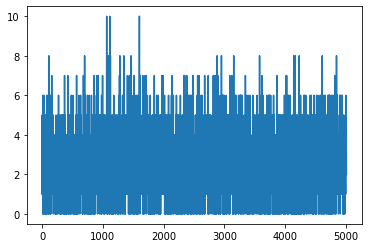

In [204]:
plt.plot(binned_spikes)

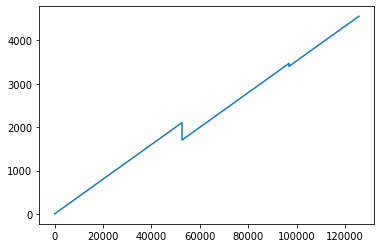

In [205]:
plt.plot(pts)

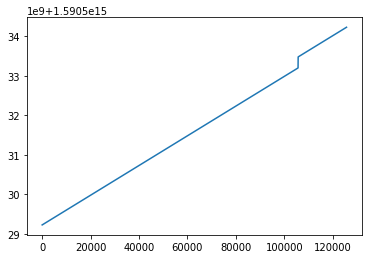

In [206]:
plt.plot(cpu_time)

In [165]:
cpu_time

array([1590529227648514, 1590529227688513, 1590529227728512, ...,
       1590534256402792, 1590534256442791, 1590534256482790])